In [1]:
import torch
import torch.nn as nn
import numpy as np
from data_process import get_data_loaders, getFeatures
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from model.TCN import TemporalConvNet

## Flight Data

In [2]:
data = pd.read_csv('flights.csv')
data.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002443,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.006425,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5


<AxesSubplot: title={'center': 'Flight 1'}, xlabel='position_x'>

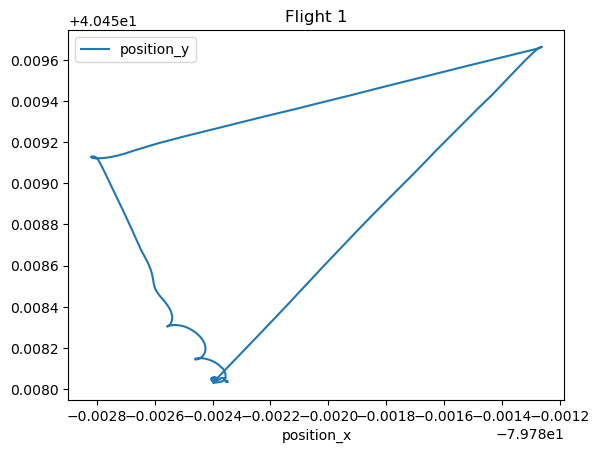

In [3]:
flight_data = data[data['flight']==1]
flight_data.plot(x='position_x', y='position_y', title='Flight 1')

We aim to predict future power in a sequence. From the engineering perspective, the future power can be related with future controls such as the acceleration. Then in this case, we consider power prediction under two scenarios: one is that we have no infomation from future, so predict the future based on current and histroic features; the other is to, beyond that, take the future trajectories as the covariates for prediciton, assuming that the mobility follows the trajectory which is usually the case when vehicle follows the navigation.

## Scenarios without covariates

### Create data loader of sequence to sequence (without Covariates)

In [4]:
# Specify the input sequence length and output sequence length
input_len, output_len = 20, 10

In [5]:
# Get all potential features of the dataloader
all_features = getFeatures(covariates=False)

# Specify the features to be used
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']

In [6]:
data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                                features=select_features, covariates=False)
"""
The outputs are: processed dataframe, training dataloader, validation dataloader, test dataloader, 
dictionary of flight number splitted by train/val/test, MinMaxScaler object (to be used for inverse transform)
"""

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']


### Models (without covariates)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# Model parameters
encoder_input_size = len(select_features)
decoder_input_size = encoder_input_size
hidden_size = 32  
num_layers = 1

#### LSTM-LSTM

In [9]:
from model.LSTM_LSTM import LSTM_LSTM

lstm_lstm = LSTM_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

pytorch_total_params = sum(p.numel() for p in lstm_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

10727


In [10]:
# Load saved model
lstm_lstm.load_state_dict(torch.load(f'saved_model/LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

#### TCN-LSTM

In [11]:
from model.TCN_LSTM import TCN_LSTM

tcn_lstm = TCN_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

pytorch_total_params = sum(p.numel() for p in tcn_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

13660


In [12]:
# Load saved model
tcn_lstm.load_state_dict(torch.load(f'saved_model/TCN_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

### Test the model

In [13]:

for seq2seq in [lstm_lstm, tcn_lstm]:

    seq2seq.eval()
    mape_list = []
    sum_mape = 0
    sum_size = 0
    r2_score_list = np.array([])
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1)

        # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
    
        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

LSTM_LSTM test MAPE: 19.1275577545166
TCN_LSTM test MAPE: 16.699588775634766


In [14]:
# reverse transform power prediction by scaler
power_idx = select_features.index('power')
power_min = scaler.data_min_[power_idx]
power_max = scaler.data_max_[power_idx]

print(power_min, power_max)

def scale_reverse(x):
    return x*(power_max - power_min) + power_min


-7.692561984673375 1004.2176683612051


In [15]:
from data_process import create_sequences
from utils import plot_output

test_flights = d_split['test']

worst_flight_mape, worst_flight_num = 0, None
best_flight_mape, best_flight_num = np.inf, None

for seq2seq in ['naive', lstm_lstm, tcn_lstm]:
    
    sum_power_mape = 0
    sum_energy_mape = 0
    sum_size = 0

    for flight_num in test_flights:

        test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
        input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                                 test_data['power'].values, input_len, output_len)

        input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
        output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

        if seq2seq == 'naive':
            targets = output_seq
            targets = targets.cpu().numpy()
            outputs = test_data['power'].mean()*np.ones((targets.shape[0], targets.shape[1]))
        
        else:
            seq2seq.eval()
            with torch.no_grad():
                outputs = seq2seq(input_seq)  # No need for target length
                # Adjust the dimensions if necessary, based on your loss function requirements
                # Example: If your outputs and targets are both [batch_size, 2, 1]
                outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
                targets = output_seq
            outputs, targets = outputs.cpu().numpy(), targets.cpu().numpy()
        
            # find best and worst flight for TCN_LSTM
            if seq2seq.name == 'TCN_LSTM':
                mape = np.mean(np.abs((outputs - targets) / targets)) * 100
                if mape < best_flight_mape:
                    best_flight_mape = mape
                    best_flight_num = flight_num
                if mape > worst_flight_mape:
                    worst_flight_mape = mape
                    worst_flight_num = flight_num

        ape_power = np.sum(np.abs((outputs - targets) / targets)) * 100
        sum_power_mape += ape_power
        # plot_output(torch.tensor(outputs), torch.tensor(targets), output_len)
        
        unscaled_power_preds = scale_reverse(outputs)
        # print(unscaled_power_preds)
        hist_energy, future_dt_energy = create_sequences(test_data['energy_consumed_unscaled'].values, 
                                                        test_data[['time_diff_unscaled', 'energy_consumed_unscaled']].values, 
                                                        input_len, output_len)
        pred_energies = np.zeros((targets.shape[0], targets.shape[1]))
        prev_energy = hist_energy[:, -1]
        for t in range(targets.shape[1]):
            pred_energies[:, t] = prev_energy + unscaled_power_preds[:, t] * future_dt_energy[:, t, 0]
            prev_energy = pred_energies[:, t]
        target_energies = future_dt_energy[:, :, 1]
        ape_energy = np.sum(np.abs((pred_energies - target_energies) / target_energies)) * 100
        sum_energy_mape += ape_energy

        # plot_output(torch.tensor(pred_energies), torch.tensor(target_energies), output_len)
        sum_size += targets.shape[0] * targets.shape[1]

    if seq2seq == 'naive':
        print(f"{seq2seq} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq} test energy MAPE: {sum_energy_mape/sum_size}")
    else:
        print(f"{seq2seq.name} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq.name} test energy MAPE: {sum_energy_mape/sum_size}")
    print()

naive test power MAPE: 15.190351613443646
naive test energy MAPE: 0.282557942354818

LSTM_LSTM test power MAPE: 9.169930312448669
LSTM_LSTM test energy MAPE: 0.11375524966816501

TCN_LSTM test power MAPE: 8.87314275072376
TCN_LSTM test energy MAPE: 0.1085292387993012



Best flight num = 201, MAPE = 5.73%


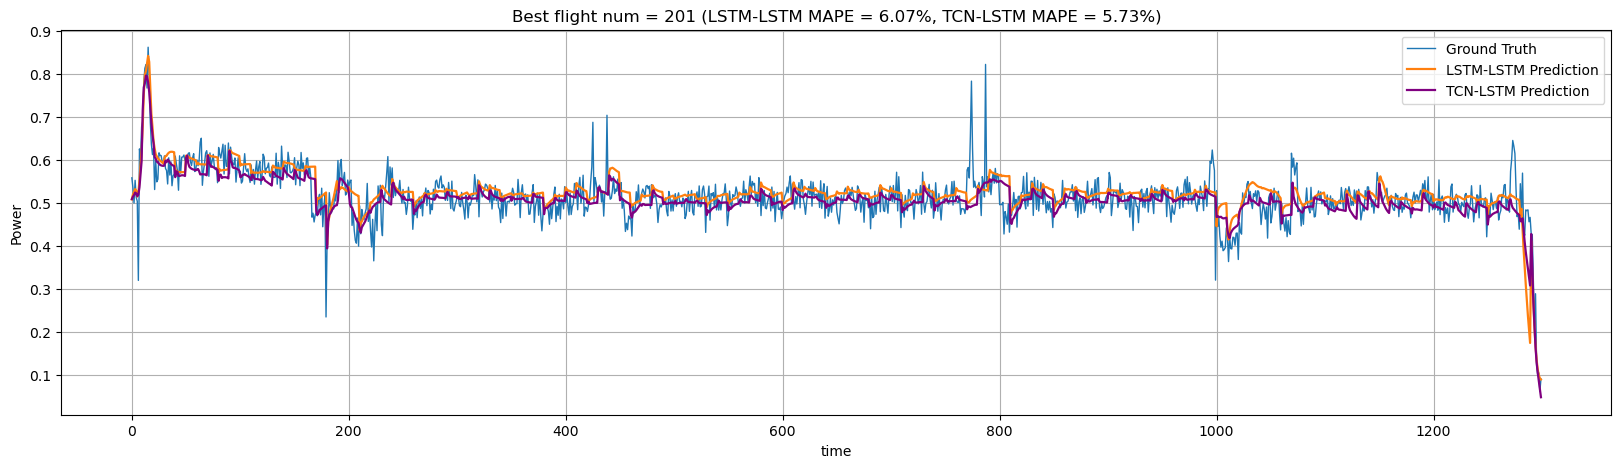

In [16]:
# plot the best flight

print(f'Best flight num = {best_flight_num}, MAPE = {best_flight_mape:.2f}%')

test_data = data[(data['flight'] == best_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(input_seq)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()

tcn_lstm.eval()
with torch.no_grad():
    outputs2 = tcn_lstm(input_seq)  # No need for target length
    outputs2 = outputs2.squeeze(-1)  # Now [batch_size, 2]
    outputs2 = outputs2.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Best flight num = {best_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, TCN-LSTM MAPE = {mape2:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()



Worst flight num = 187, MAPE = 13.43%


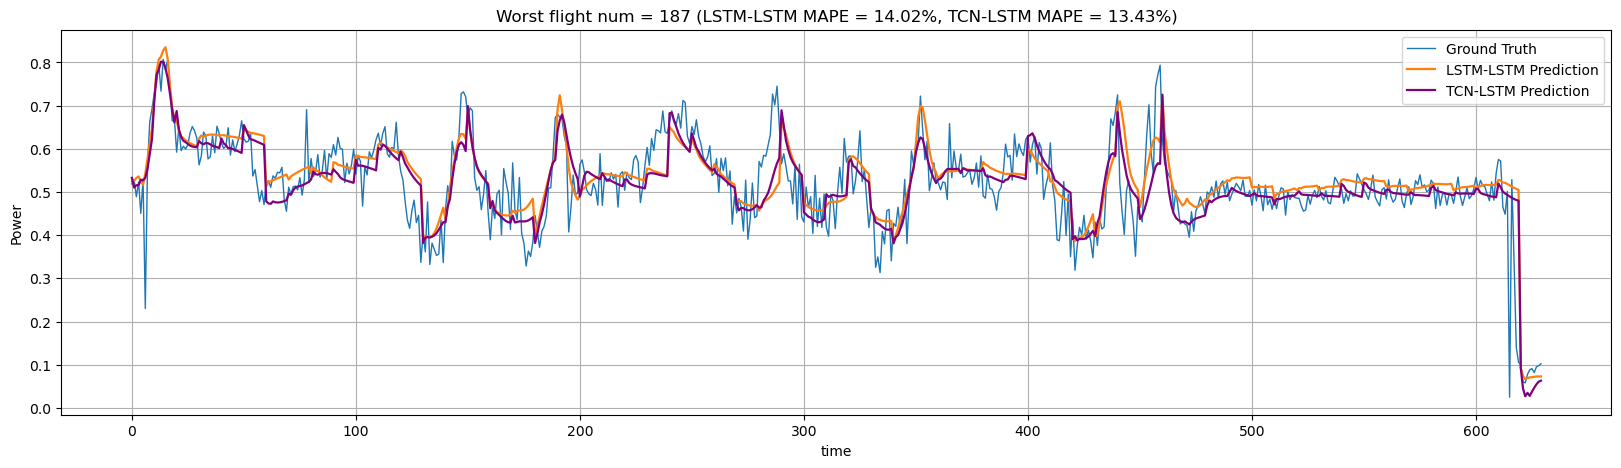

In [18]:
# plot the worst flight

print(f'Worst flight num = {worst_flight_num}, MAPE = {worst_flight_mape:.2f}%')

test_data = data[(data['flight'] == worst_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(input_seq)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()

tcn_lstm.eval()
with torch.no_grad():
    outputs2 = tcn_lstm(input_seq)  # No need for target length
    outputs2 = outputs2.squeeze(-1)  # Now [batch_size, 2]
    outputs2 = outputs2.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Worst flight num = {worst_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, TCN-LSTM MAPE = {mape2:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()

## Scenarios with covariates

In [11]:
# Specify the input sequence length and output sequence length
input_len, output_len = 20, 10

In [12]:
# Specify the features to be used
data = pd.read_csv('flights.csv')
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']

data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                                features=select_features, covariates=True)

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power', 'x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']


### Models (with covariates)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
# Model parameters
encoder_input_size = len(select_features)
decoder_input_size = encoder_input_size
covariates_size = 6 # [x, y, z, delta_x, delta_y, delta_z]
hidden_size = 32  
num_layers = 1

print(encoder_input_size)
print(decoder_input_size)

7
7


#### DeepTCN

In [21]:
from model.DeepTCN import DeepTCN

deepTCN = DeepTCN(num_series=encoder_input_size, num_blocks=3, 
                  kernel_size=3, hidden_channels=64, num_covariates=covariates_size).to(device)

pytorch_total_params = sum(p.numel() for p in deepTCN.parameters() if p.requires_grad)
print(pytorch_total_params)

73473


In [22]:
deepTCN.load_state_dict(torch.load(f'saved_model/DeepTCN_best_selected_model_{input_len}_{output_len}.pt', map_location='cpu'))

<All keys matched successfully>

#### LSTM_LSTM

In [15]:
class LSTM_LSTM(nn.Module):
    def __init__(self, hist_input_size, covariates_size, input_len, output_len, lstm_num_hidden, num_layers=1):
        super(LSTM_LSTM, self).__init__()
        self.encoder = nn.LSTM(hist_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hist_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_num_hidden + covariates_size, hist_input_size)
        self.input_len = input_len
        self.output_len = output_len

    def forward(self, x_encoder, x_decoder):
        # x: (batch_size, input_len, input_size)
        _, (h, c) = self.encoder(x_encoder)
        xt = x_encoder[:, -1, :].unsqueeze(1)
        outputs = []
        for t in range(self.output_len):
            output, (h, c) = self.decoder(xt, (h, c))
            covariate = x_decoder[:, t, :].unsqueeze(1)
            output = torch.cat([covariate, output], dim=-1)
            output = self.fc(output)
            xt = output
            outputs.append(output[:, :, -1].unsqueeze(2))

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [16]:
#from model.LSTM_LSTM import LSTM_LSTM

hist_input_size = len(select_features)
covariate_size = 6
input_len = 20
output_len = 10
hidden_size = 32
num_layers = 1

lstm_lstm = LSTM_LSTM(hist_input_size, covariate_size, 
                    input_len, output_len, hidden_size, num_layers=num_layers).to(device)

pytorch_total_params = sum(p.numel() for p in lstm_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

10769


In [19]:
lstm_lstm.load_state_dict(torch.load(f'saved_model/LSTM_LSTM_covariates_select_best_model_{input_len}-{output_len}.pt', map_location='cpu'))

<All keys matched successfully>

#### TCN-LSTM

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, covariate_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size+covariate_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell, covariates):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for t in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            covariate = covariates[:, t, :].unsqueeze(1)
            output = torch.cat((covariate, output), dim=2)
            output = self.fc(output) 
            outputs.append(output[:, :, -1].unsqueeze(2))
            x = output

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, covariate_size, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, covariate_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, historic_inputs, covariates):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(historic_inputs)
        xt = historic_inputs[:, -1, :].unsqueeze(1) 
        outputs = self.decoder(xt, h, c, covariates) # (batch_size, output_len, 1)
        return outputs

In [33]:
#from model.TCN_LSTM import TCN_LSTM

hist_input_size = len(select_features)
covariate_size = 6
hidden_size = 32  
num_layers = 1

tcn_lstm = TCN_LSTM(hist_input_size, input_len, covariate_size, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)
pytorch_total_params = sum(p.numel() for p in tcn_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

13702


In [37]:
# Load saved model
tcn_lstm.load_state_dict(torch.load(f'saved_model/TCN_LSTM_covariate_select_best_model_{input_len}-{output_len}.pt', map_location='cpu'))

<All keys matched successfully>

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power', 'x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']
Test loss: 0.0024378758389502764
MAPE: 21.5001277923584


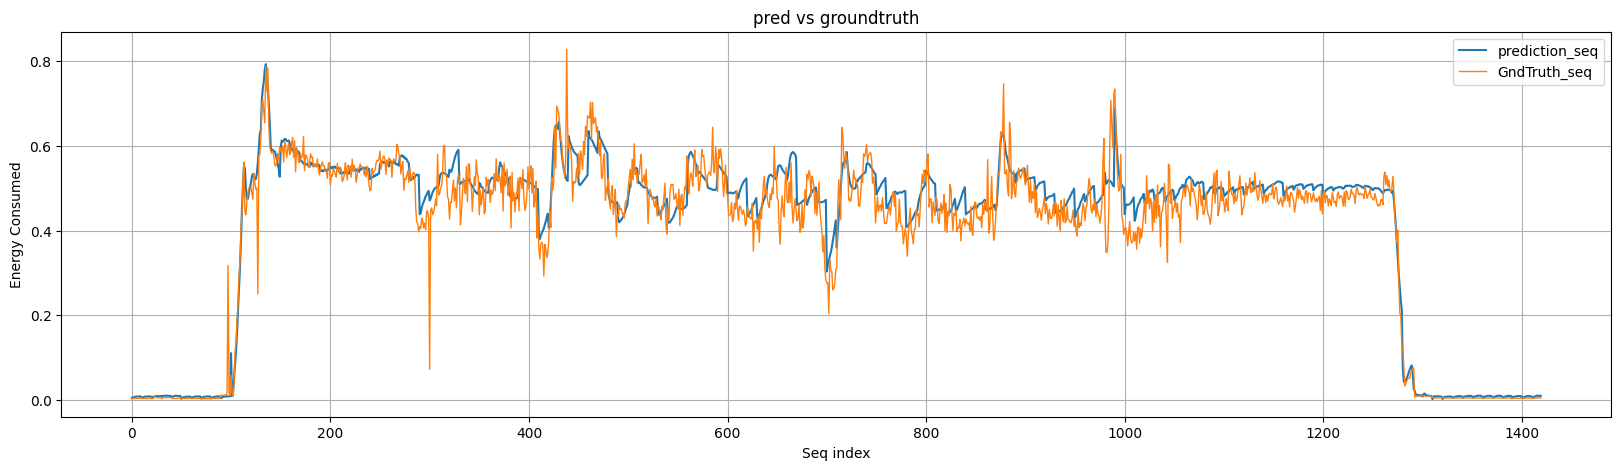

In [26]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
#seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_covariates_best_model_{input_len}-{output_len}.pt', map_location=torch.device('cpu')))
lstm_features = select_features + getFeatures(covariates=True)[-6:]
print(lstm_features)

# Test the model
lstm_lstm.eval()
flight_num = 270 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[lstm_features].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    hist_inputs = input_seq[:, :, :hist_input_size].to(device)
    covariates = input_seq[:, :output_len, hist_input_size:].to(device)
    targets = output_seq.to(device)
    outputs = lstm_lstm(hist_inputs, covariates)

    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    # print(torch.mean(torch.abs((outputs - targets) / targets)*100,  axis=0))
    print(f"MAPE: {mape}")

    # print(outputs.shape)
    # print(targets.shape)
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


### Test the model

In [38]:
deepTCN.name = 'DeepTCN'
lstm_lstm.name = 'LSTM_LSTM'
tcn_lstm.name = 'TCN_LSTM'

for seq2seq in [tcn_lstm]:

    seq2seq.eval()
    sum_mape = 0
    sum_size = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        hist_inputs = inputs[:, :, :encoder_input_size].to(device)
        covariates = inputs[:, :output_len, encoder_input_size:].to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(hist_inputs, covariates)

        # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
        if len(outputs.shape) == 3:
            outputs = outputs.squeeze(-1)
        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

TCN_LSTM test MAPE: 17.866600036621094


In [40]:
# reverse transform power prediction by scaler
power_idx = select_features.index('power')
power_min = scaler.data_min_[power_idx]
power_max = scaler.data_max_[power_idx]

print(power_min, power_max)

def scale_reverse(x):
    return x*(power_max - power_min) + power_min

-7.692561984673375 1004.2176683612051


In [39]:
features_with_covariates = select_features + ['x_future', 'y_future', 'z_future','x_change', 'y_change', 'z_change']
features_with_covariates

['payload',
 'wind_speed',
 'wind_angle',
 'linear_acceleration_x',
 'linear_acceleration_y',
 'linear_acceleration_z',
 'power',
 'x_future',
 'y_future',
 'z_future',
 'x_change',
 'y_change',
 'z_change']

In [50]:
from data_process import create_sequences
from utils import plot_output

test_flights = d_split['test']

worst_flight_mape, worst_flight_num = 0, None
best_flight_mape, best_flight_num = np.inf, None

for seq2seq in ['naive', lstm_lstm, deepTCN, tcn_lstm]:
    
    sum_power_mape = 0
    sum_energy_mape = 0
    sum_size = 0

    for flight_num in test_flights:

        test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
        input_seq, output_seq = create_sequences(test_data[features_with_covariates].values, 
                                                 test_data['power'].values, input_len, output_len)

        input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
        output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

        hist_inputs = input_seq[:, :, :encoder_input_size].to(device)
        covariates = input_seq[:, :output_len, encoder_input_size:].to(device)


        if seq2seq == 'naive':
            targets = output_seq
            targets = targets.cpu().numpy()
            outputs = test_data['power'].mean()*np.ones((targets.shape[0], targets.shape[1]))
        
        else:
            seq2seq.eval()
            with torch.no_grad():
                outputs = seq2seq(hist_inputs, covariates)
                if len(outputs.shape) == 3:
                    outputs = outputs.squeeze(-1)
            targets = output_seq.cpu().numpy() 
            outputs = outputs.cpu().numpy()
        
            # find best and worst flight for TCN_LSTM
            if seq2seq.name == 'TCN_LSTM':
                mape = np.mean(np.abs((outputs - targets) / targets)) * 100
                if mape < best_flight_mape:
                    best_flight_mape = mape
                    best_flight_num = flight_num
                if mape > worst_flight_mape:
                    worst_flight_mape = mape
                    worst_flight_num = flight_num

        ape_power = np.sum(np.abs((outputs - targets) / targets)) * 100
        sum_power_mape += ape_power
        # plot_output(torch.tensor(outputs), torch.tensor(targets), output_len)
        
        unscaled_power_preds = scale_reverse(outputs)
        # print(unscaled_power_preds)
        hist_energy, future_dt_energy = create_sequences(test_data['energy_consumed_unscaled'].values, 
                                                        test_data[['time_diff_unscaled', 'energy_consumed_unscaled']].values, 
                                                        input_len, output_len)
        pred_energies = np.zeros((targets.shape[0], targets.shape[1]))
        prev_energy = hist_energy[:, -1]
        for t in range(targets.shape[1]):
            pred_energies[:, t] = prev_energy + unscaled_power_preds[:, t] * future_dt_energy[:, t, 0]
            prev_energy = pred_energies[:, t]
        target_energies = future_dt_energy[:, :, 1]
        ape_energy = np.sum(np.abs((pred_energies - target_energies) / target_energies)) * 100
        sum_energy_mape += ape_energy

        # plot_output(torch.tensor(pred_energies), torch.tensor(target_energies), output_len)
        sum_size += targets.shape[0] * targets.shape[1]

    if seq2seq == 'naive':
        print(f"{seq2seq} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq} test energy MAPE: {sum_energy_mape/sum_size}")
    else:
        print(f"{seq2seq.name} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq.name} test energy MAPE: {sum_energy_mape/sum_size}")
    print()

naive test power MAPE: 14.894103000927457
naive test energy MAPE: 0.28213316380439846

LSTM_LSTM test power MAPE: 8.685468186771464
LSTM_LSTM test energy MAPE: 0.11146621612422854

DeepTCN test power MAPE: 9.78302071794748
DeepTCN test energy MAPE: 0.1505137483656875

TCN_LSTM test power MAPE: 8.621134033363681
TCN_LSTM test energy MAPE: 0.1088092029363223



In [51]:
best_flight_num, worst_flight_num

(201, 187)

Best flight num = 201, MAPE = 5.89%


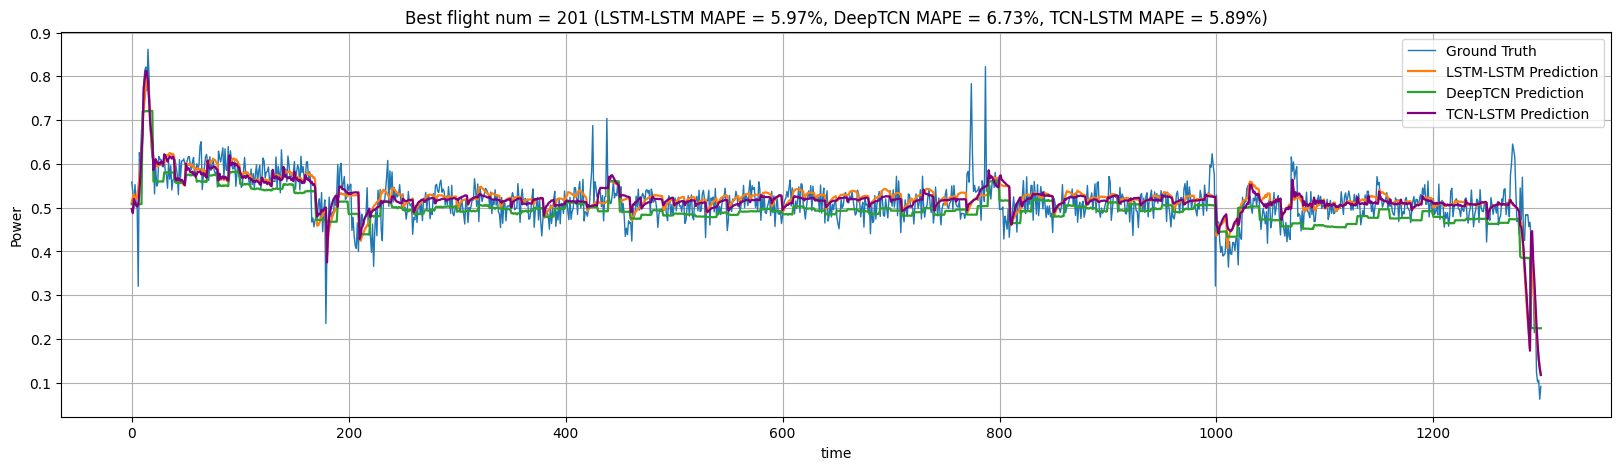

In [47]:
# plot the best flight

print(f'Best flight num = {best_flight_num}, MAPE = {best_flight_mape:.2f}%')

test_data = data[(data['flight'] == best_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[features_with_covariates].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

hist_inputs = input_seq[:, :, :encoder_input_size].to(device)
covariates = input_seq[:, :output_len, encoder_input_size:].to(device)

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(hist_inputs, covariates)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()
    
deepTCN.eval()
with torch.no_grad():
    outputs2 = deepTCN(hist_inputs, covariates)  # No need for target length
    outputs2 = outputs2.cpu().numpy()
    
tcn_lstm.eval()
with torch.no_grad():
    outputs3 = tcn_lstm(hist_inputs, covariates)  # No need for target length
    outputs3 = outputs3.squeeze(-1)  # Now [batch_size, 2]
    outputs3 = outputs3.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100
mape3 = np.mean(np.abs((outputs3 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
pred_powers3 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))
    pred_powers3.extend(list(outputs3[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='DeepTCN Prediction', linewidth=1.6)
plt.plot(pred_powers3, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Best flight num = {best_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, DeepTCN MAPE = {mape2:.2f}%, TCN-LSTM MAPE = {mape3:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()



Worst flight num = 187, MAPE = 13.01%


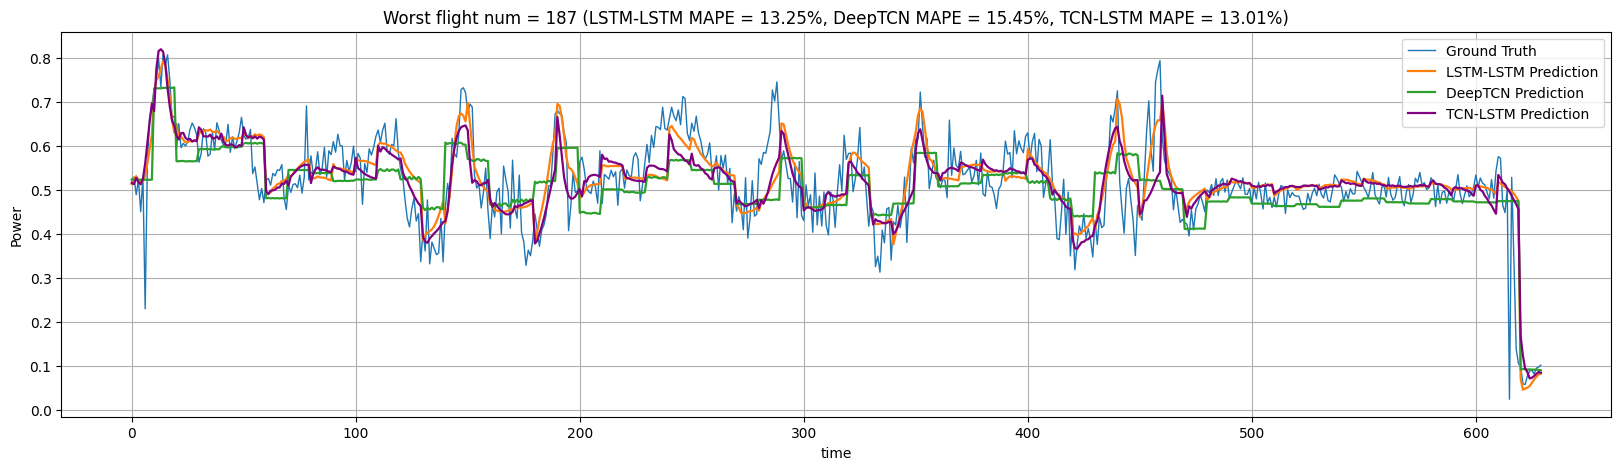

In [49]:

print(f'Worst flight num = {worst_flight_num}, MAPE = {worst_flight_mape:.2f}%')

test_data = data[(data['flight'] == worst_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[features_with_covariates].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

hist_inputs = input_seq[:, :, :encoder_input_size].to(device)
covariates = input_seq[:, :output_len, encoder_input_size:].to(device)

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(hist_inputs, covariates)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()
    
deepTCN.eval()
with torch.no_grad():
    outputs2 = deepTCN(hist_inputs, covariates)  # No need for target length
    outputs2 = outputs2.cpu().numpy()
    
tcn_lstm.eval()
with torch.no_grad():
    outputs3 = tcn_lstm(hist_inputs, covariates)  # No need for target length
    outputs3 = outputs3.squeeze(-1)  # Now [batch_size, 2]
    outputs3 = outputs3.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100
mape3 = np.mean(np.abs((outputs3 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
pred_powers3 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))
    pred_powers3.extend(list(outputs3[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='DeepTCN Prediction', linewidth=1.6)
plt.plot(pred_powers3, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Worst flight num = {worst_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, DeepTCN MAPE = {mape2:.2f}%, TCN-LSTM MAPE = {mape3:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()

